In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from matplotlib_venn import venn3
from pathlib import Path
import sys
from itertools import combinations
from importlib import reload
import sc_addons

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.1 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
os.chdir("/mnt/d/Huitian_Practice/exp391")


In [3]:
adata = sc.read_h5ad('exp391_paga.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 7801 × 4645
    obs: 'cell_type', 'n_genes', 'percent_mito', 'n_counts', 'y_pred', 'use', 'louvain', 'day', 'dpt_pseudotime'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obs['cell_type_general'] = [x[0] for x in adata.obs['cell_type']]
adata.obs['day'] = [x[1] for x in adata.obs['cell_type']]
adata.obs['day'] = [x.replace('P','0') for x in adata.obs['day']]

gene_n = len(adata.raw.var)

In [8]:
adata.obs['cell_type_general'][0:4]

AAACCCAAGAGGCGTT-1    C
AAACCCACAATGACCT-1    C
AAACCCACACGACAAG-1    N
AAACCCACAGAGGTAC-1    A
Name: cell_type_general, dtype: object

In [5]:
louvain_newlabel_uniq = list(set(adata.obs['louvain']))
louvain_newlabel_uniq.sort()
louvain_newlabel_uniq

['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']

In [6]:
feature_file = "/mnt/d/Huitian_Practice/exp391/filtered_feature_bc_matrix/features.tsv"

In [7]:
features_df = pd.read_csv(feature_file,header=None,sep='\t')
all_genes = list(features_df[1])

In [8]:
len(all_genes)

22638

In [9]:
de_dir = os.getcwd() + "/2_DE"
Path(de_dir).mkdir(parents=True,exist_ok=True)

In [10]:
os.chdir(de_dir)
labels_uniq = louvain_newlabel_uniq

In [11]:
obs_useCol = 'louvain'

In [12]:
cp_dir = de_dir + '/eachCluster_vs_All'
Path(cp_dir).mkdir(parents=True,exist_ok=True)

... storing 'day' as categorical
... storing 'cell_type_general' as categorical


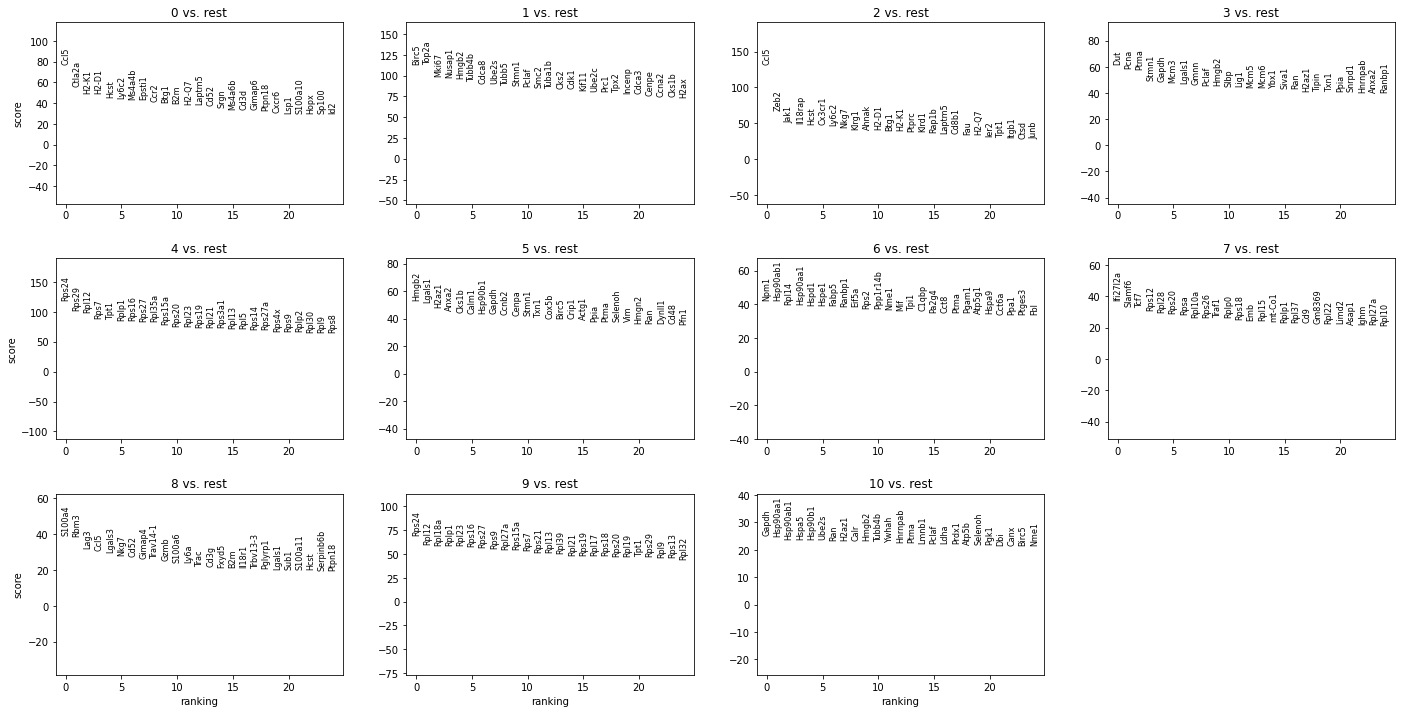

In [13]:
sc.tl.rank_genes_groups(adata,'louvain',method='t-test',key_added='t-test',n_genes=gene_n)
sc.pl.rank_genes_groups(adata,n_genes=25,sharey=False,key='t-test')

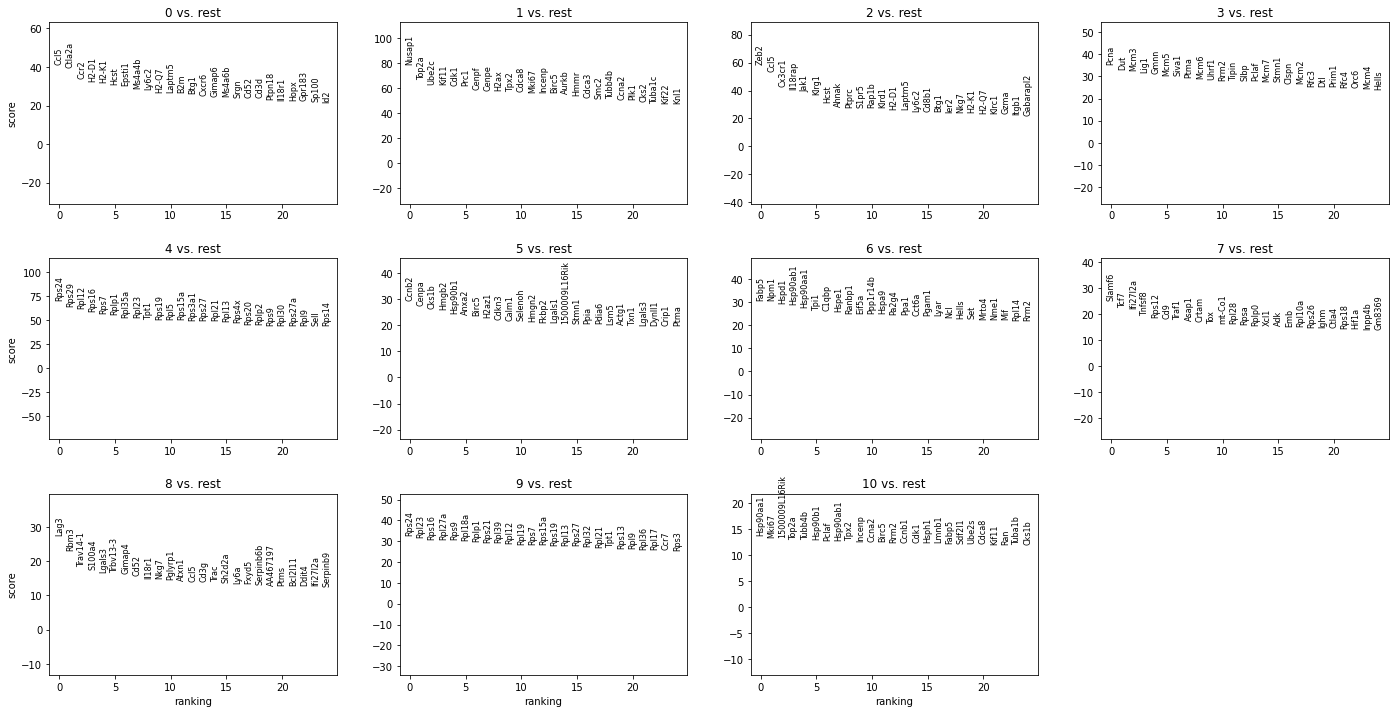

In [14]:
sc.tl.rank_genes_groups(adata, obs_useCol, method='t-test_overestim_var',key_added='t-test_ov',n_genes=gene_n)
sc.pl.rank_genes_groups(adata,n_genes=25,sharey=False,key='t-test_ov')

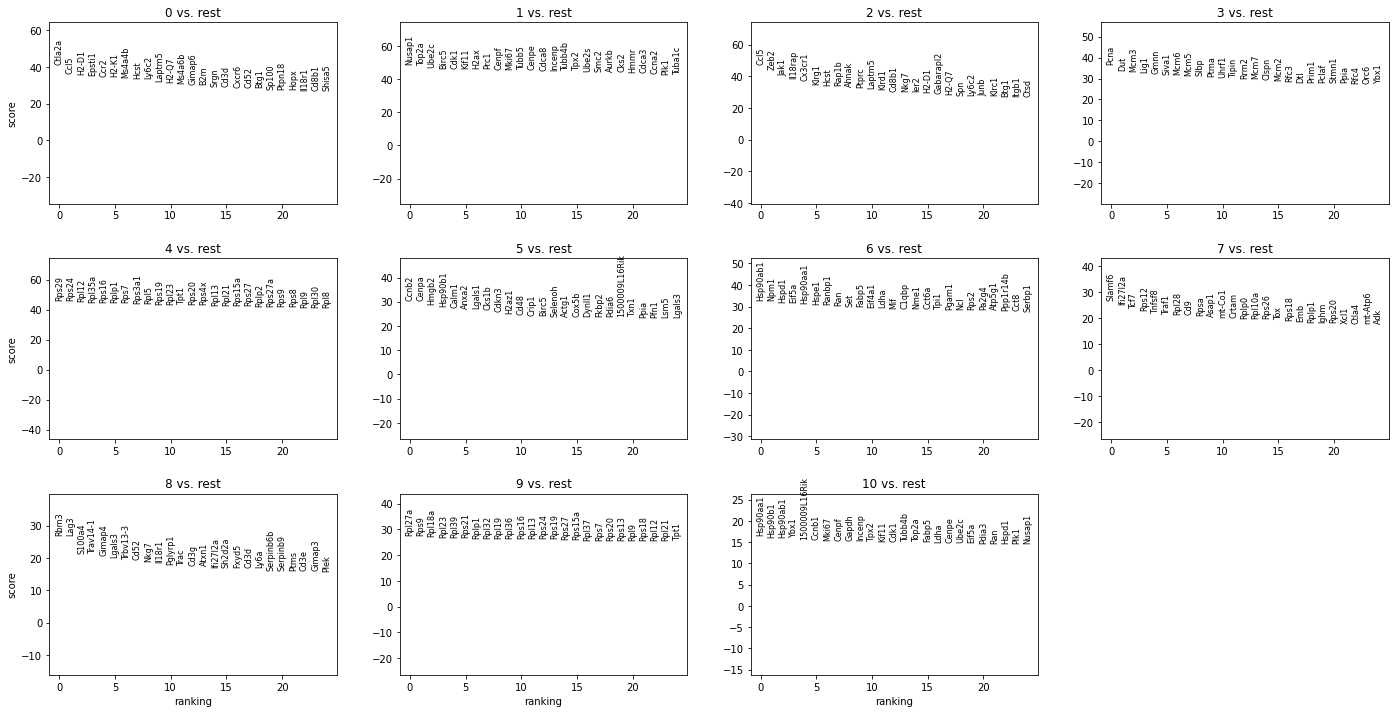

In [15]:
sc.tl.rank_genes_groups(adata,obs_useCol,method='wilcoxon',key_added = 'wilcoxon', n_genes=gene_n)
sc.pl.rank_genes_groups(adata,n_genes=25,sharey=False,key='wilcoxon')

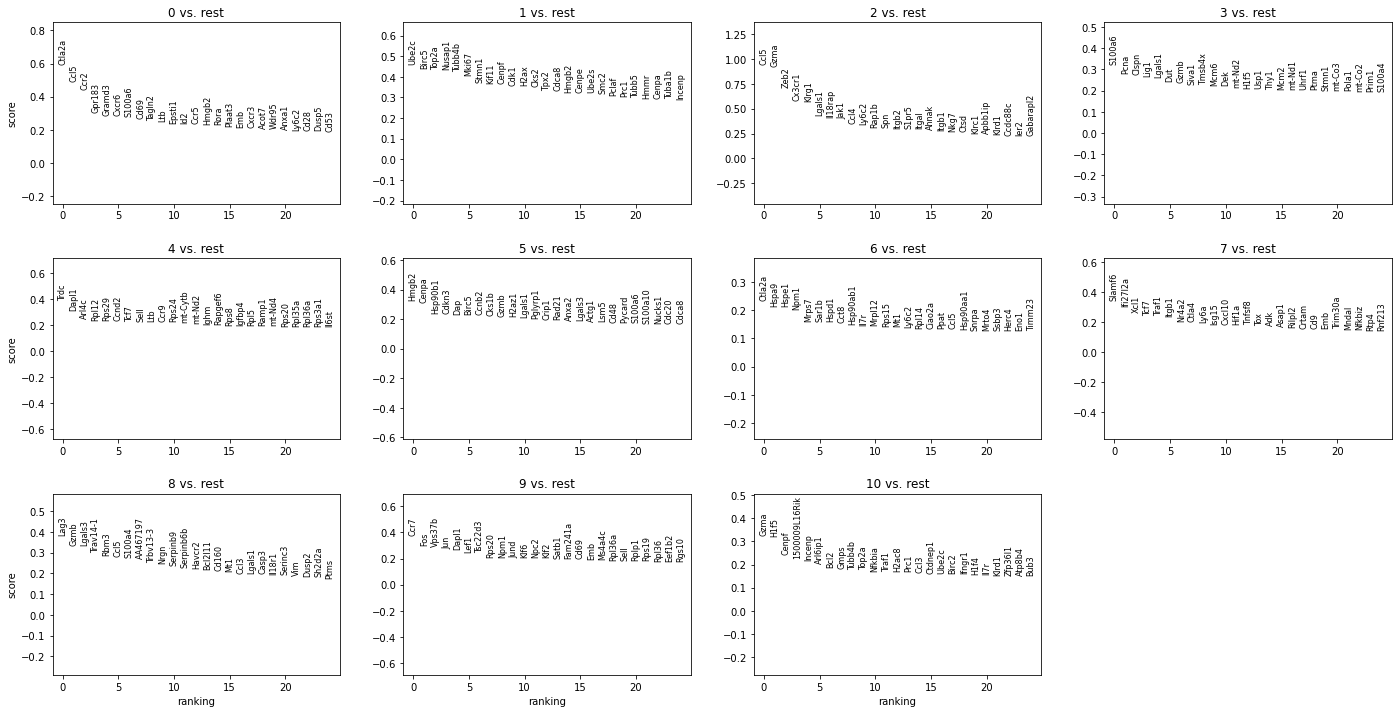

In [16]:
sc.tl.rank_genes_groups(adata,obs_useCol,method='logreg',key_added='logreg',n_genes=gene_n)
sc.pl.rank_genes_groups(adata,n_genes=25,sharey=False, key="logreg")

In [17]:
os.chdir(cp_dir)
cps=['wilcoxon','t-test','t-test_ov','logreg']

for l_t in labels_uniq:
    genes_df_l_t = pd.DataFrame({'gene_names':all_genes})
    dict_l_t = {}
    for cp in cps:
        if cp != 'logreg':
            cp_names = adata.uns[cp]['names'][l_t]
            cp_fc = adata.uns[cp]['logfoldchanges'][l_t]
            cp_score = adata.uns[cp]['scores'][l_t]
            cp_padj = adata.uns[cp]['pvals_adj'][l_t]
            if (cp == 't-test_ov'):
                cp_name = 't-test_overestim_var'
                cp_df = pd.DataFrame({"gene_names":cp_names, "%s_logfc"%cp_name: cp_fc, "%s_padj"%cp_name:cp_padj, "%s_score"%cp_name:cp_score})
            else:
                cp_df = pd.DataFrame({"gene_names":cp_names, "%s_logfc"%cp: cp_fc, "%s_padj"%cp:cp_padj, "%s_score"%cp:cp_score})
                
            genes_df_l_t = pd.merge(genes_df_l_t, cp_df, how='outer',on="gene_names")
            cp_df = cp_df[cp_df[cp_df.columns[2]] <= 0.05]
            cp_df = cp_df[cp_df[cp_df.columns[1]] > 0]
            dict_l_t[cp] = cp_df['gene_names']
        else:
            cp_names = adata.uns[cp]['names'][l_t]
            cp_score = adata.uns[cp]['scores'][l_t]
            cp_df = pd.DataFrame({"gene_names":cp_names,"%s_score"%cp:cp_score})
            genes_df_l_t = pd.merge(genes_df_l_t, cp_df, how='outer', on='gene_names')
    genes_df_l_t.to_csv("%s_differential.csv"%l_t, index=False)
    

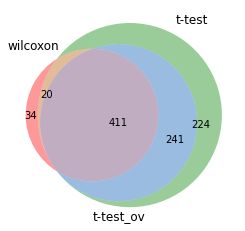

In [18]:
venn3([set(dict_l_t[cps[0]]),set(dict_l_t[cps[1]]),set(dict_l_t[cps[2]])],tuple(cps[:3]))
outname = "%s_venn.png"%l_t
plt.savefig(outname)


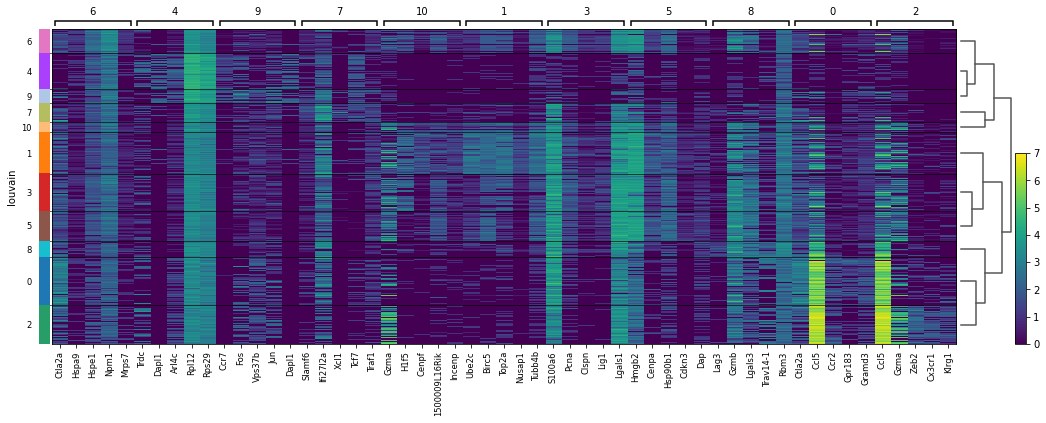

In [19]:
heatmap = sc.pl.rank_genes_groups_heatmap(adata,n_genes=5,key='logreg',groupby=obs_useCol,show_gene_labels=True,save='logreg_heatmap.png')

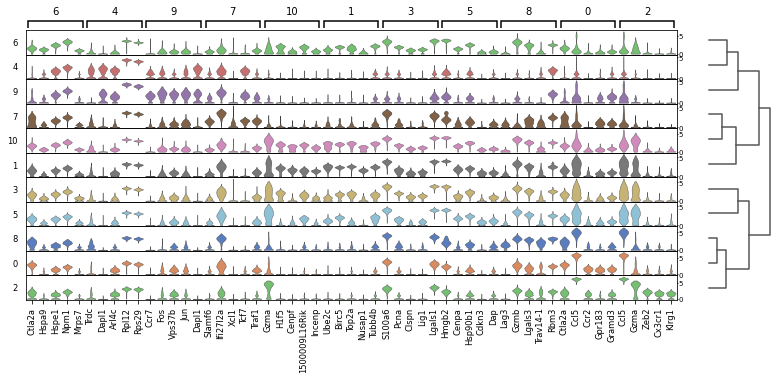

In [20]:
sc.pl.rank_genes_groups_stacked_violin(adata,n_genes=5,key='logreg',groupby=obs_useCol,save='logreg_violin.png')

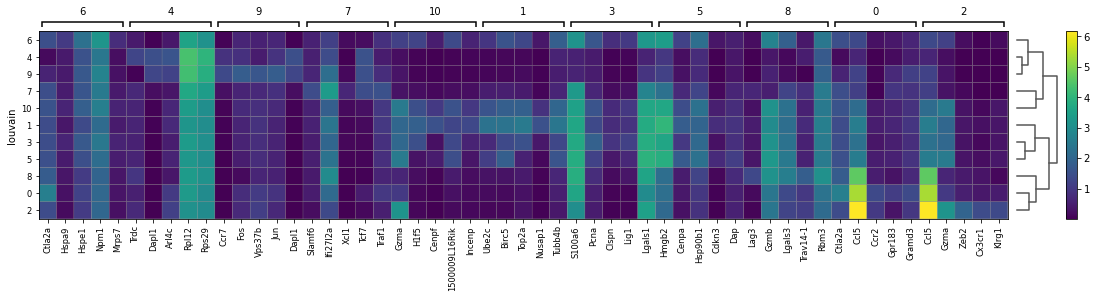

In [21]:
sc.pl.rank_genes_groups_matrixplot(adata,n_genes=5,key='logreg',groupby =obs_useCol,save='logreg_matrix.png')

In [22]:
cp_dir = de_dir +'/Cluster_vs_Cluster'
Path(cp_dir).mkdir(parents=True,exist_ok=True)

['0', '1']


Trying to set attribute `.uns` of view, copying.


0 1 wilcoxon
0 1 t-test
0 1 t-test_overestim_var


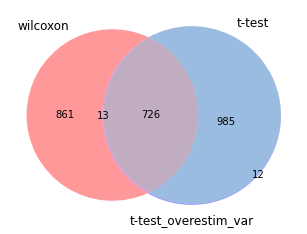

1 0 wilcoxon
1 0 t-test
1 0 t-test_overestim_var


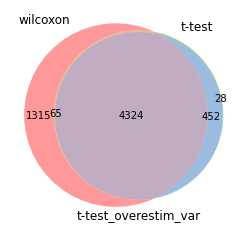

['0', '2']


Trying to set attribute `.uns` of view, copying.


0 2 wilcoxon
0 2 t-test
0 2 t-test_overestim_var


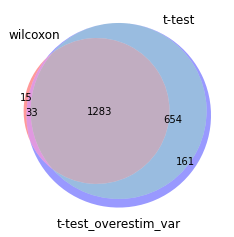

2 0 wilcoxon
2 0 t-test
2 0 t-test_overestim_var


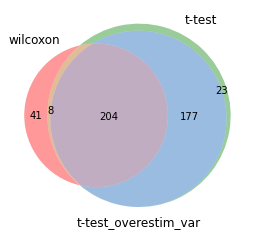

['0', '3']


Trying to set attribute `.uns` of view, copying.


0 3 wilcoxon
0 3 t-test
0 3 t-test_overestim_var


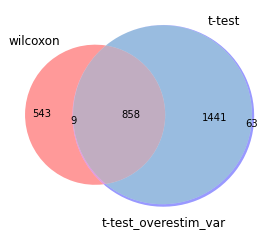

3 0 wilcoxon
3 0 t-test
3 0 t-test_overestim_var


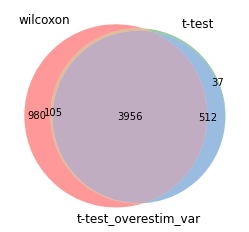

['0', '4']


Trying to set attribute `.uns` of view, copying.


0 4 wilcoxon
0 4 t-test
0 4 t-test_overestim_var


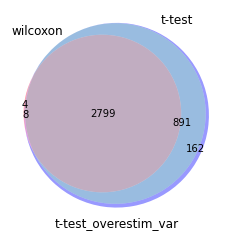

4 0 wilcoxon
4 0 t-test
4 0 t-test_overestim_var


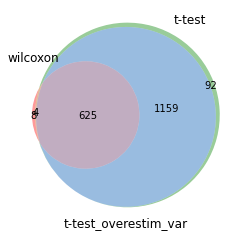

['0', '5']


Trying to set attribute `.uns` of view, copying.


0 5 wilcoxon
0 5 t-test
0 5 t-test_overestim_var


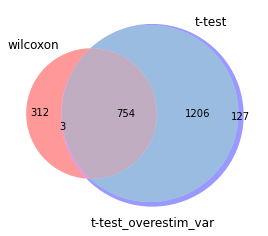

5 0 wilcoxon
5 0 t-test
5 0 t-test_overestim_var


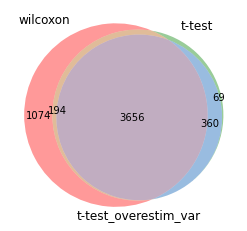

['0', '6']


Trying to set attribute `.uns` of view, copying.


0 6 wilcoxon
0 6 t-test
0 6 t-test_overestim_var


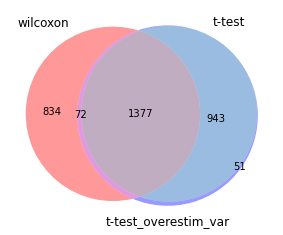

6 0 wilcoxon
6 0 t-test
6 0 t-test_overestim_var


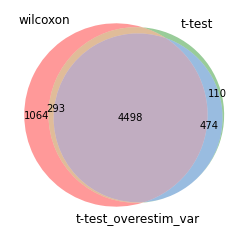

['0', '7']


Trying to set attribute `.uns` of view, copying.


0 7 wilcoxon
0 7 t-test
0 7 t-test_overestim_var


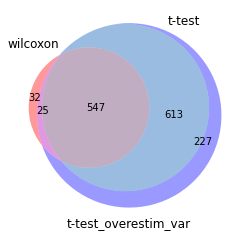

7 0 wilcoxon
7 0 t-test
7 0 t-test_overestim_var


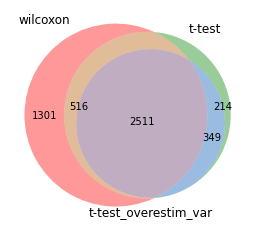

['0', '8']


Trying to set attribute `.uns` of view, copying.


0 8 wilcoxon
0 8 t-test
0 8 t-test_overestim_var


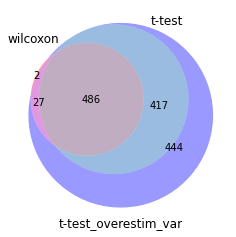

8 0 wilcoxon
8 0 t-test
8 0 t-test_overestim_var


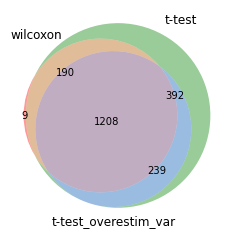

['0', '9']
0 9 wilcoxon


Trying to set attribute `.uns` of view, copying.


0 9 t-test
0 9 t-test_overestim_var


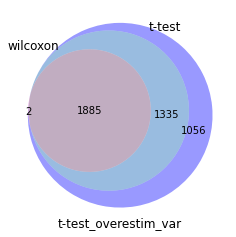

9 0 wilcoxon
9 0 t-test
9 0 t-test_overestim_var


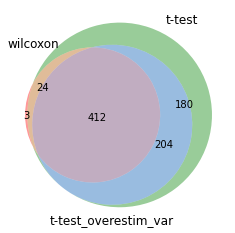

['0', '10']


Trying to set attribute `.uns` of view, copying.


0 10 wilcoxon
0 10 t-test
0 10 t-test_overestim_var


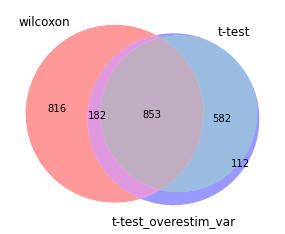

10 0 wilcoxon
10 0 t-test
10 0 t-test_overestim_var


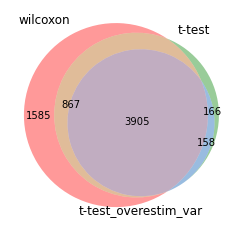

['0', '1']


Trying to set attribute `.uns` of view, copying.


0 1 wilcoxon
0 1 t-test
0 1 t-test_overestim_var


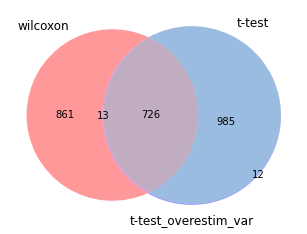

1 0 wilcoxon
1 0 t-test
1 0 t-test_overestim_var


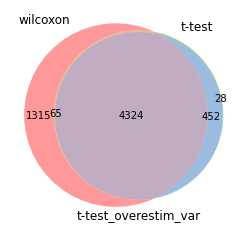

['1', '2']


Trying to set attribute `.uns` of view, copying.


1 2 wilcoxon
1 2 t-test
1 2 t-test_overestim_var


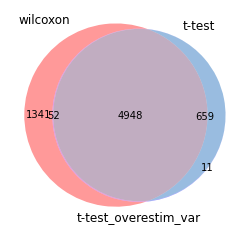

2 1 wilcoxon
2 1 t-test
2 1 t-test_overestim_var


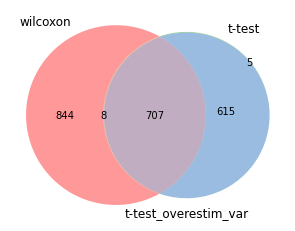

['1', '3']


Trying to set attribute `.uns` of view, copying.


1 3 wilcoxon
1 3 t-test
1 3 t-test_overestim_var


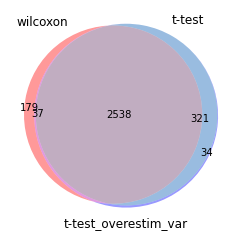

3 1 wilcoxon
3 1 t-test
3 1 t-test_overestim_var


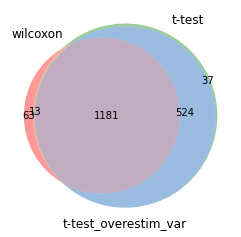

['1', '4']


Trying to set attribute `.uns` of view, copying.


1 4 wilcoxon
1 4 t-test
1 4 t-test_overestim_var


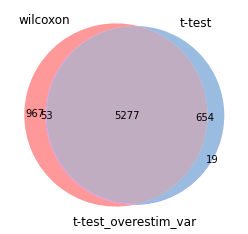

4 1 wilcoxon
4 1 t-test
4 1 t-test_overestim_var


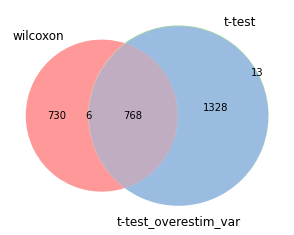

['1', '5']


Trying to set attribute `.uns` of view, copying.


1 5 wilcoxon
1 5 t-test
1 5 t-test_overestim_var


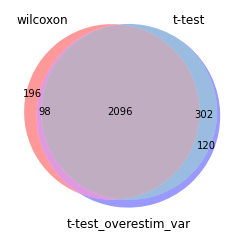

5 1 wilcoxon
5 1 t-test
5 1 t-test_overestim_var


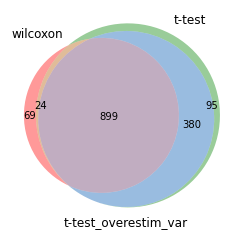

['1', '6']


Trying to set attribute `.uns` of view, copying.


1 6 wilcoxon
1 6 t-test
1 6 t-test_overestim_var


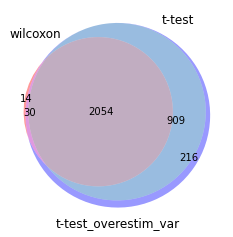

6 1 wilcoxon
6 1 t-test
6 1 t-test_overestim_var


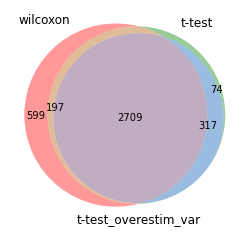

['1', '7']


Trying to set attribute `.uns` of view, copying.


1 7 wilcoxon
1 7 t-test
1 7 t-test_overestim_var


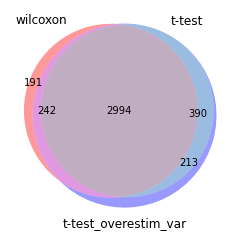

7 1 wilcoxon
7 1 t-test
7 1 t-test_overestim_var


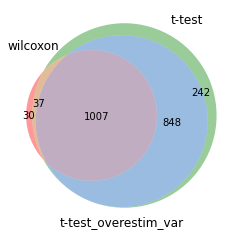

['1', '8']


Trying to set attribute `.uns` of view, copying.


1 8 wilcoxon
1 8 t-test
1 8 t-test_overestim_var


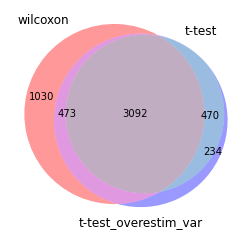

8 1 wilcoxon
8 1 t-test
8 1 t-test_overestim_var


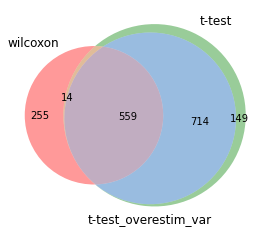

['1', '9']


Trying to set attribute `.uns` of view, copying.


1 9 wilcoxon
1 9 t-test
1 9 t-test_overestim_var


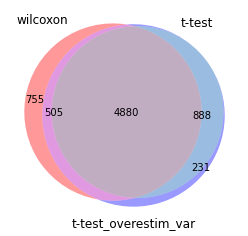

9 1 wilcoxon
9 1 t-test
9 1 t-test_overestim_var


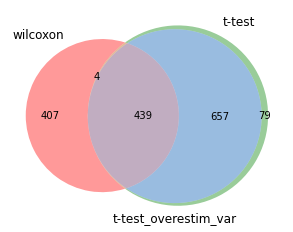

['1', '10']


Trying to set attribute `.uns` of view, copying.


1 10 wilcoxon
1 10 t-test
1 10 t-test_overestim_var


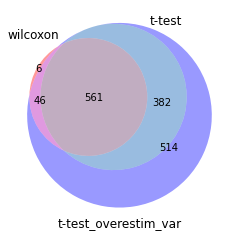

10 1 wilcoxon
10 1 t-test
10 1 t-test_overestim_var


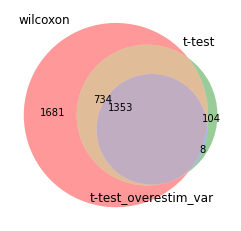

['0', '2']


Trying to set attribute `.uns` of view, copying.


0 2 wilcoxon
0 2 t-test
0 2 t-test_overestim_var


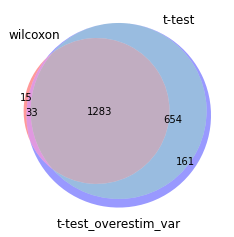

2 0 wilcoxon
2 0 t-test
2 0 t-test_overestim_var


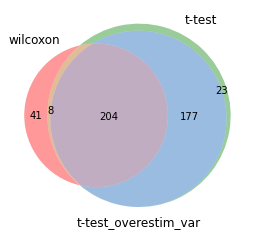

['1', '2']


In [ ]:
obs_useCol='louvain'
cps = ['wilcoxon','t-test', 't-test_overestim_var']
louvain_unique = [int(x) for x in list(set(adata.obs['louvain']))]
louvain_unique.sort()
louvain_unique = [str(x) for x in louvain_unique]
for i in louvain_unique:
    for j in louvain_unique:
        if i != j:
            adata_ij = adata.copy()
            adata_ij = adata_ij[[True if x in [i,j] else False for x in adata_ij.obs['louvain'].values],:]
            sc_addons.multitest_venn(adata_ij,cps,obs_useCol,cp_dir)